Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

## DISCLAIMER. This book is probably useless apart from warming up dplyr/ggplot skills.

All sources are in R_sources/house_price/ folder.

In [20]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

# load sources
house_prices <- source('main.R', local = TRUE)$value

# load data
combined_dataset <- house_prices$helpers$load_data()

# dimensions check
list(
    combined_dataset, 
    combined_dataset %>% filter(dataSource == "train"), 
    combined_dataset %>% filter(dataSource == "test")
) %>% purrr::map(dim) %>% show_list

2919 82 
 1460 82 
 1459 82

In [3]:
character_colnames <- house_prices$helpers$get_character_colnames(combined_dataset)
numeric_colnames <- house_prices$helpers$get_numeric_colnames(combined_dataset)

c(character_colnames %>% length, numeric_colnames %>% length) %>% show_list
character_colnames %>% show_list
numeric_colnames %>% show_list

45 35

Alley BldgType BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual CentralAir Condition1 Condition2 Electrical ExterCond Exterior1st Exterior2nd ExterQual Fence FireplaceQu Foundation Functional GarageCond GarageFinish GarageQual GarageType Heating HeatingQC HouseStyle KitchenQual LandContour LandSlope LotConfig LotShape MasVnrType MiscFeature MoSold MSSubClass MSZoning Neighborhood PavedDrive PoolQC RoofMatl RoofStyle SaleCondition SaleType Street Utilities

BedroomAbvGr BsmtFinSF1 BsmtFinSF2 BsmtFullBath BsmtHalfBath BsmtUnfSF EnclosedPorch Fireplaces FullBath GarageArea GarageCars GarageYrBlt GrLivArea HalfBath KitchenAbvGr LotArea LotFrontage LowQualFinSF MasVnrArea MiscVal OpenPorchSF OverallCond OverallQual PoolArea SalePrice ScreenPorch TotalBsmtSF TotRmsAbvGrd WoodDeckSF X1stFlrSF X2ndFlrSF X3SsnPorch YearBuilt YearRemodAdd YrSold

In [4]:
categ_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_character_colnames(combined_dataset), SalePrice)

categ_data %>% glimpse

Observations: 2,919
Variables: 46
$ Alley         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ BldgType      <chr> "1Fam", "1Fam", "1Fam", "1Fam", "1Fam", "1Fam", "1Fam...
$ BsmtCond      <chr> "TA", "TA", "TA", "Gd", "TA", "TA", "TA", "TA", "TA",...
$ BsmtExposure  <chr> "No", "Gd", "Mn", "No", "Av", "No", "Av", "Mn", "No",...
$ BsmtFinType1  <chr> "GLQ", "ALQ", "GLQ", "ALQ", "GLQ", "GLQ", "GLQ", "ALQ...
$ BsmtFinType2  <chr> "Unf", "Unf", "Unf", "Unf", "Unf", "Unf", "Unf", "BLQ...
$ BsmtQual      <chr> "Gd", "Gd", "Gd", "TA", "Gd", "Gd", "Ex", "Gd", "TA",...
$ CentralAir    <chr> "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y"...
$ Condition1    <chr> "Norm", "Feedr", "Norm", "Norm", "Norm", "Norm", "Nor...
$ Condition2    <chr> "Norm", "Norm", "Norm", "Norm", "Norm", "Norm", "Norm...
$ Electrical    <chr> "SBrkr", "SBrkr", "SBrkr", "SBrkr", "SBrkr", "SBrkr",...
$ ExterCond     <chr> "TA", "TA", "TA", "TA", "TA", "TA", "TA", "TA", "TA",...
$ Exterior1st   <c

In [5]:
numeric_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_numeric_colnames(combined_dataset))

numeric_data %>% glimpse

Observations: 2,919
Variables: 35
$ BedroomAbvGr  <int> 3, 3, 3, 3, 4, 1, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 2,...
$ BsmtFinSF1    <int> 706, 978, 486, 216, 655, 732, 1369, 859, 0, 851, 906,...
$ BsmtFinSF2    <int> 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ BsmtFullBath  <int> 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,...
$ BsmtHalfBath  <int> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ BsmtUnfSF     <int> 150, 284, 434, 540, 490, 64, 317, 216, 952, 140, 134,...
$ EnclosedPorch <int> 0, 0, 0, 272, 0, 0, 0, 228, 205, 0, 0, 0, 0, 0, 176, ...
$ Fireplaces    <int> 0, 1, 1, 1, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0,...
$ FullBath      <int> 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 2,...
$ GarageArea    <int> 548, 460, 608, 642, 836, 480, 636, 484, 468, 205, 384...
$ GarageCars    <int> 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 1, 3, 1, 3, 1, 2, 2, 2,...
$ GarageYrBlt   <int> 2003, 1976, 2001, 1998, 2000, 1993, 2004, 1973, 1931,...
$ GrLivArea     <i

# Entropy of attribute distributions

The bigger the entropy the more meaningful is the variable. Zero entropy means constant distibution of a factor and thus it's zero predictive power.

In [6]:
entropy <- house_prices$attributes_selection$entropy

categ_vars_by_entropy <- entropy$arrange_vars(categ_data %>% select(-SalePrice))
numeric_vars_by_entropy <- entropy$arrange_vars(numeric_data %>% select(-SalePrice))

show_table(
    categ_vars_by_entropy %>% head, 
    categ_vars_by_entropy %>% tail,
    numeric_vars_by_entropy %>% head, 
    numeric_vars_by_entropy %>% tail
)

var,entropy
Utilities,0.01262749
PoolQC,0.03820308
Street,0.03850369
Condition2,0.10643374
RoofMatl,0.13851938
Heating,0.13977521
var,entropy
BsmtFinType1,2.454724
Exterior1st,2.723429
Exterior2nd,2.800720


# "Normal Paper" applied to SalePrice

var,value,normed_value
price,582933.00000,5.060412
price,611657.00000,5.421982
price,625000.00000,5.589940
price,745000.00000,7.100466
price,755000.00000,7.226343
price_log,13.27583,3.133736
price_log,13.32393,3.254149
price_log,13.34551,3.308173
price_log,13.52114,3.747857
price_log,13.53447,3.781237


var,L2
price,7.4623329
price_log,0.6496421


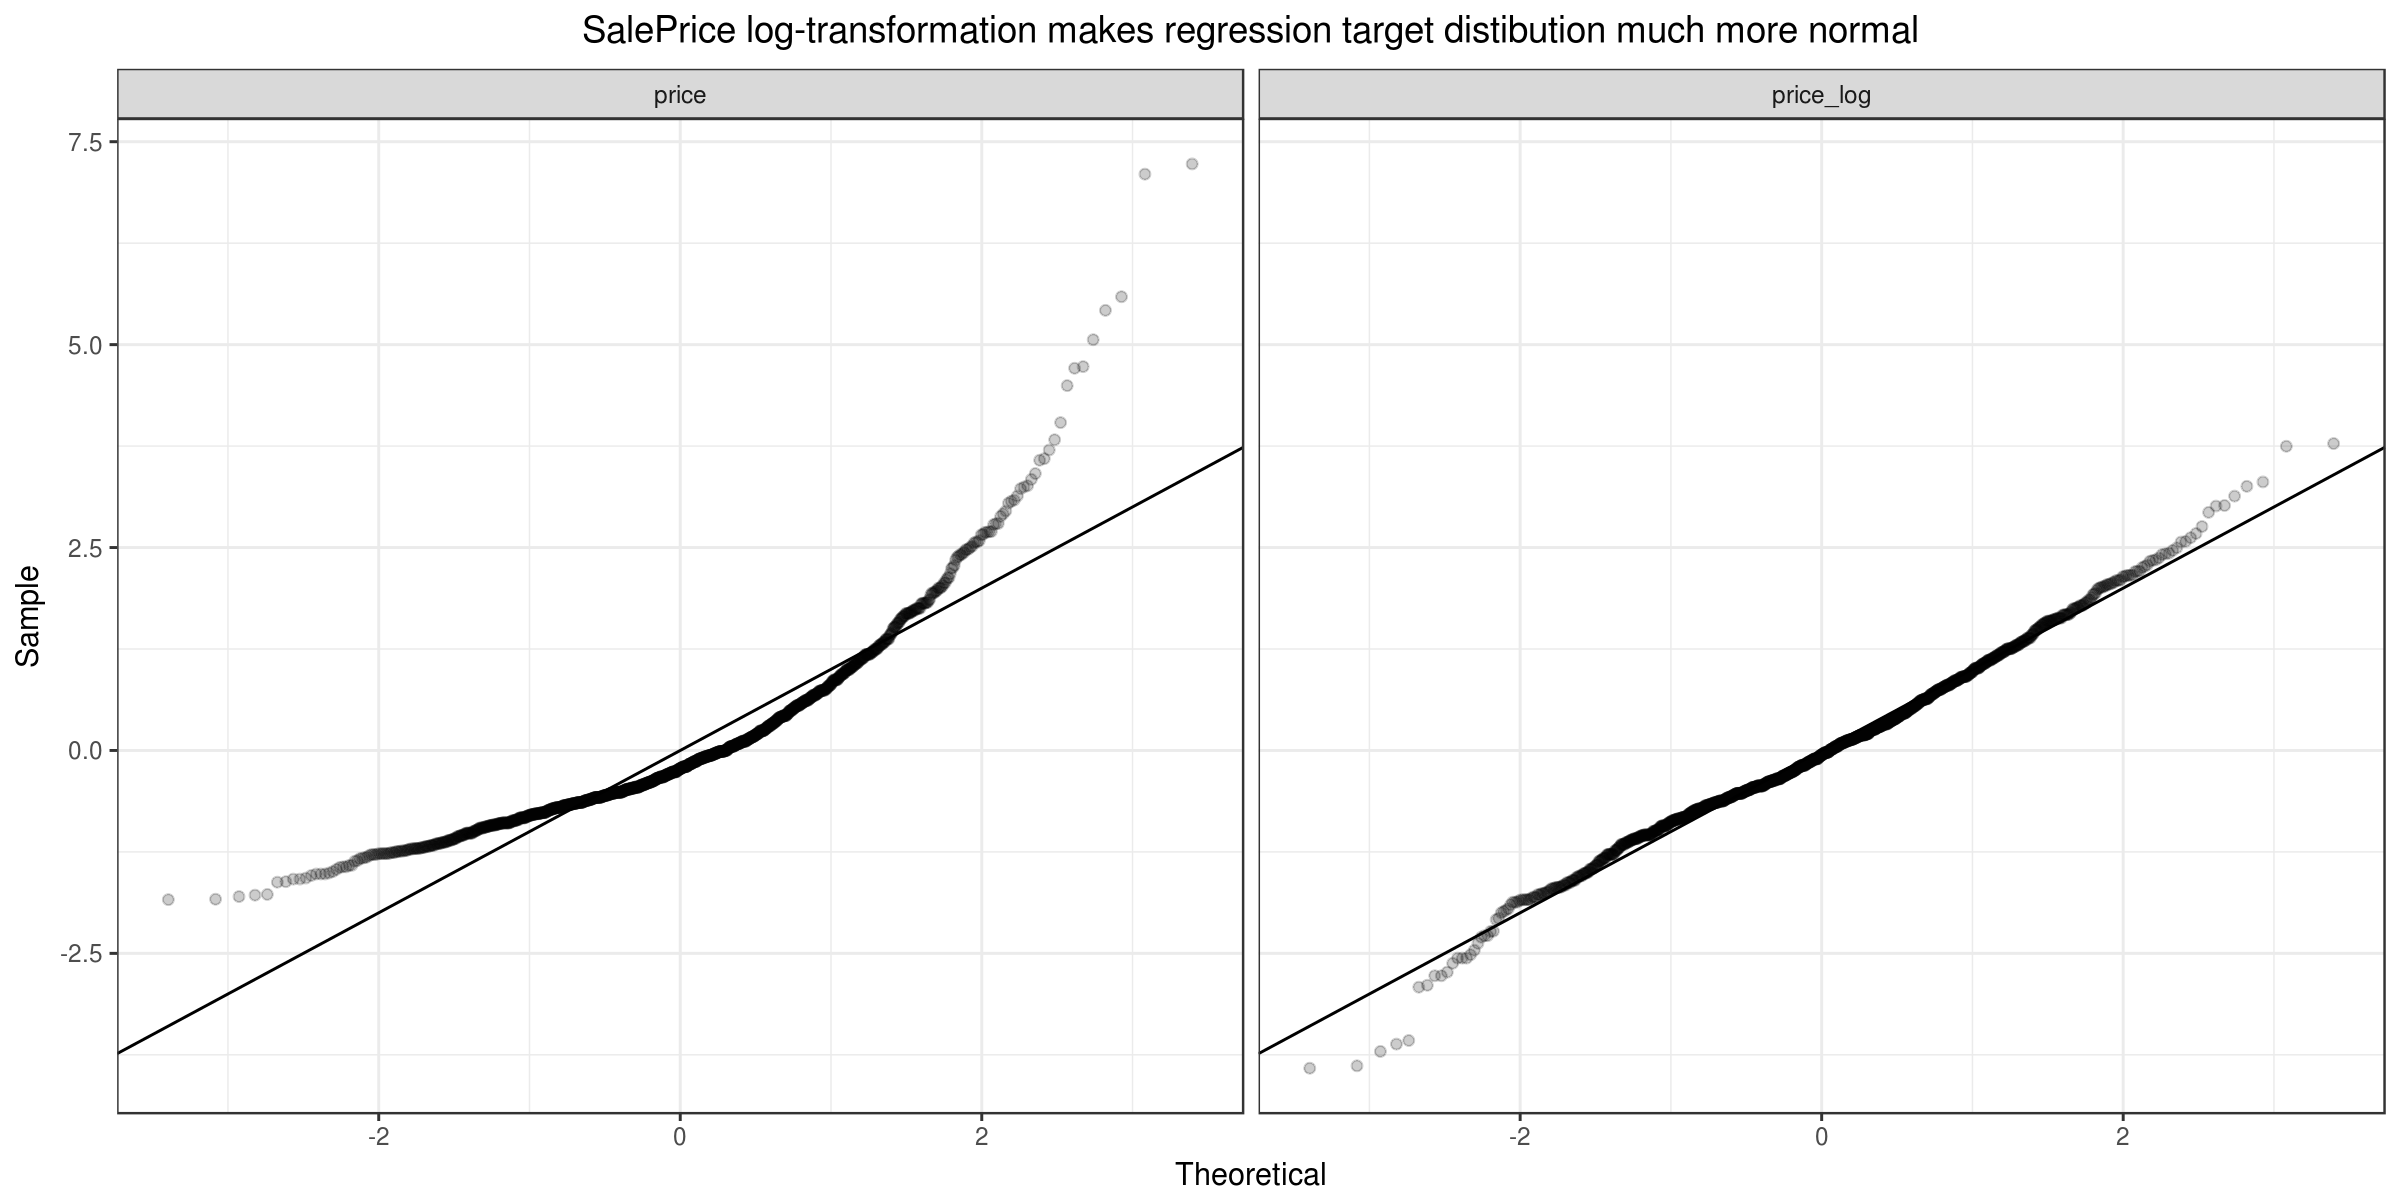

In [7]:
target_normal_paper <-
    combined_dataset %>% 
    select(price=SalePrice) %>% 
    na.omit %>%
    mutate(
        price_log = log(price)
    ) %>%
    gather(var, value) %>%
    group_by(var) %>%
    mutate(
        normed_value = (value - mean(value)) / sd(value)
    )

show_table(
    target_normal_paper %>% arrange(var, value) %>% top_n(5, value), 
    cols = 2
)

# Deviation from theoretical normal distribution in terms of L2 norm
target_normal_paper %>%
group_by(var, normed_value) %>%
arrange(var, normed_value) %>%
summarise(
    k = n()
) %>%
mutate(
    empirical = cumsum(k) / sum(k),
    theoretical = pnorm(normed_value),
    L2_delta = k*(empirical - theoretical)**2
) %>% 
group_by(var) %>%
summarise(
    L2 = sum(L2_delta)
)

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res=200)

target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
ylab("Sample") + xlab("Theoretical") +
labs(title = "SalePrice log-transformation makes regression target distibution much more normal")

# Separation between groups

This is custom measure of how levels of categorical variables are separated between each other relative to sale price. The bigger is the separation the more should be variable meaningful for the price prediction. If there is no separation between levels than this variable is useless.

In [21]:
groups_separation <- house_prices$attributes_selection$groups_separation

precalculated <- 
    groups_separation$precalculated(
        df = categ_data,
        target_var = SalePrice
    )

precalculated %>% head(5)

categ_vars_by_groups_separation <- groups_separation$arrange_vars(categ_data, SalePrice)

show_table(
    categ_vars_by_groups_separation %>% head, 
    categ_vars_by_groups_separation %>% tail
)

var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
Alley,Grvl,50,122219.1,34780.78,0.03424658,168000.6,0.02808219,38370.38
Alley,Pave,41,168000.6,38370.38,0.02808219,183452.1,0.93767123,80667.15
Alley,NA,1369,183452.1,80667.15,0.93767123,NA,NA,NA
BldgType,2fmCon,31,128432.3,35458.55,0.02123288,133541.1,0.03561644,27833.25
BldgType,Duplex,52,133541.1,27833.25,0.03561644,135911.6,0.02945205,41013.22


var,score
Utilities,0.0002047587
LotConfig,0.0005070409
Functional,0.0006479951
MoSold,0.0007162101
PoolQC,0.0010659277
Condition2,0.0012226735
var,score
BsmtFinType1,0.1211155
CentralAir,0.2042301
GarageFinish,0.2756040


### Visualising separation by two opposite cases

In [10]:
# Helper function that orderes factor levels by SalePrice's mean value at that level.
# Otherwise ggplot will by default order levels lexicographically.

order_factor_by_target <- house_prices$attributes_selection$order_factor_by_target

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
)$ExterQual %>% levels %>% show_list

Fa TA Gd Ex

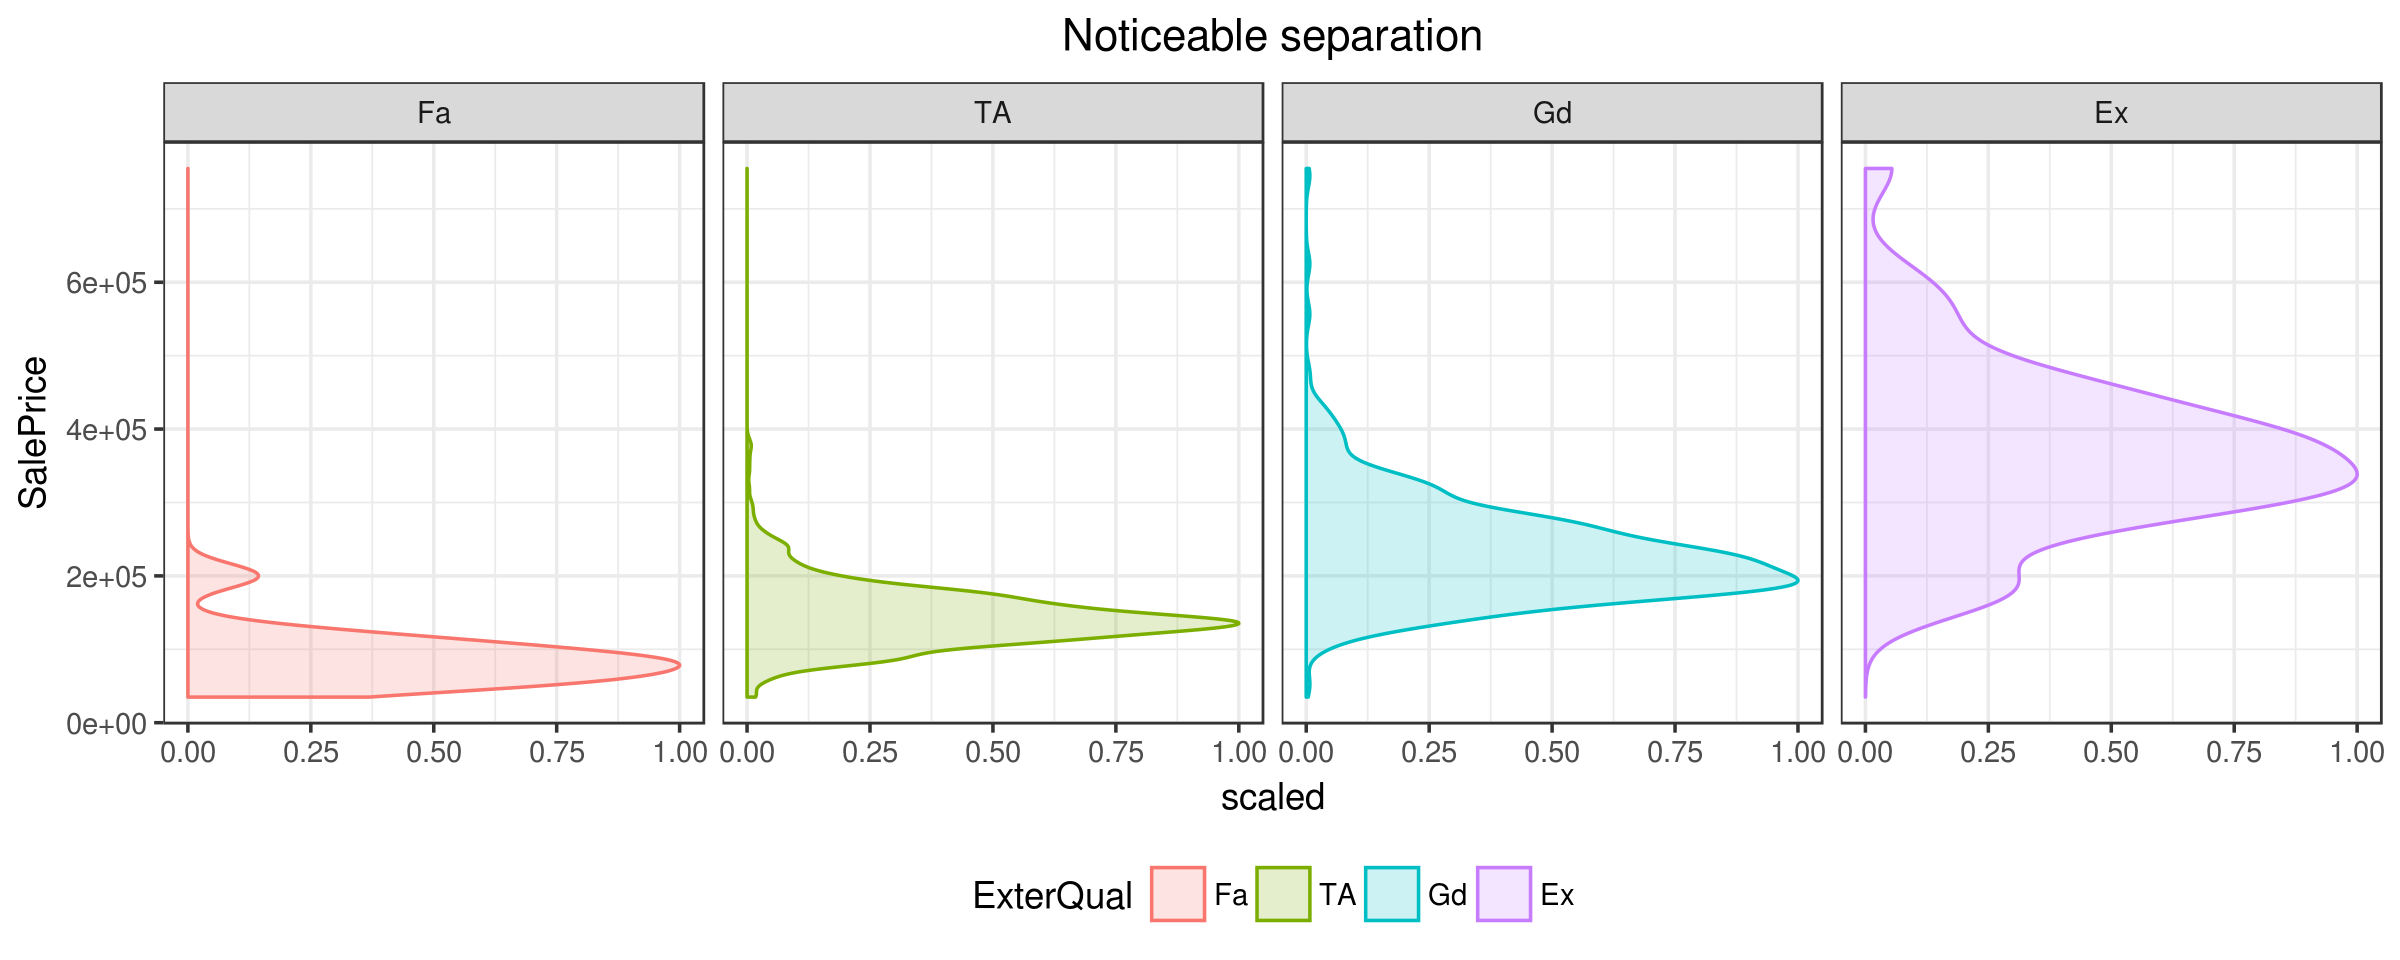

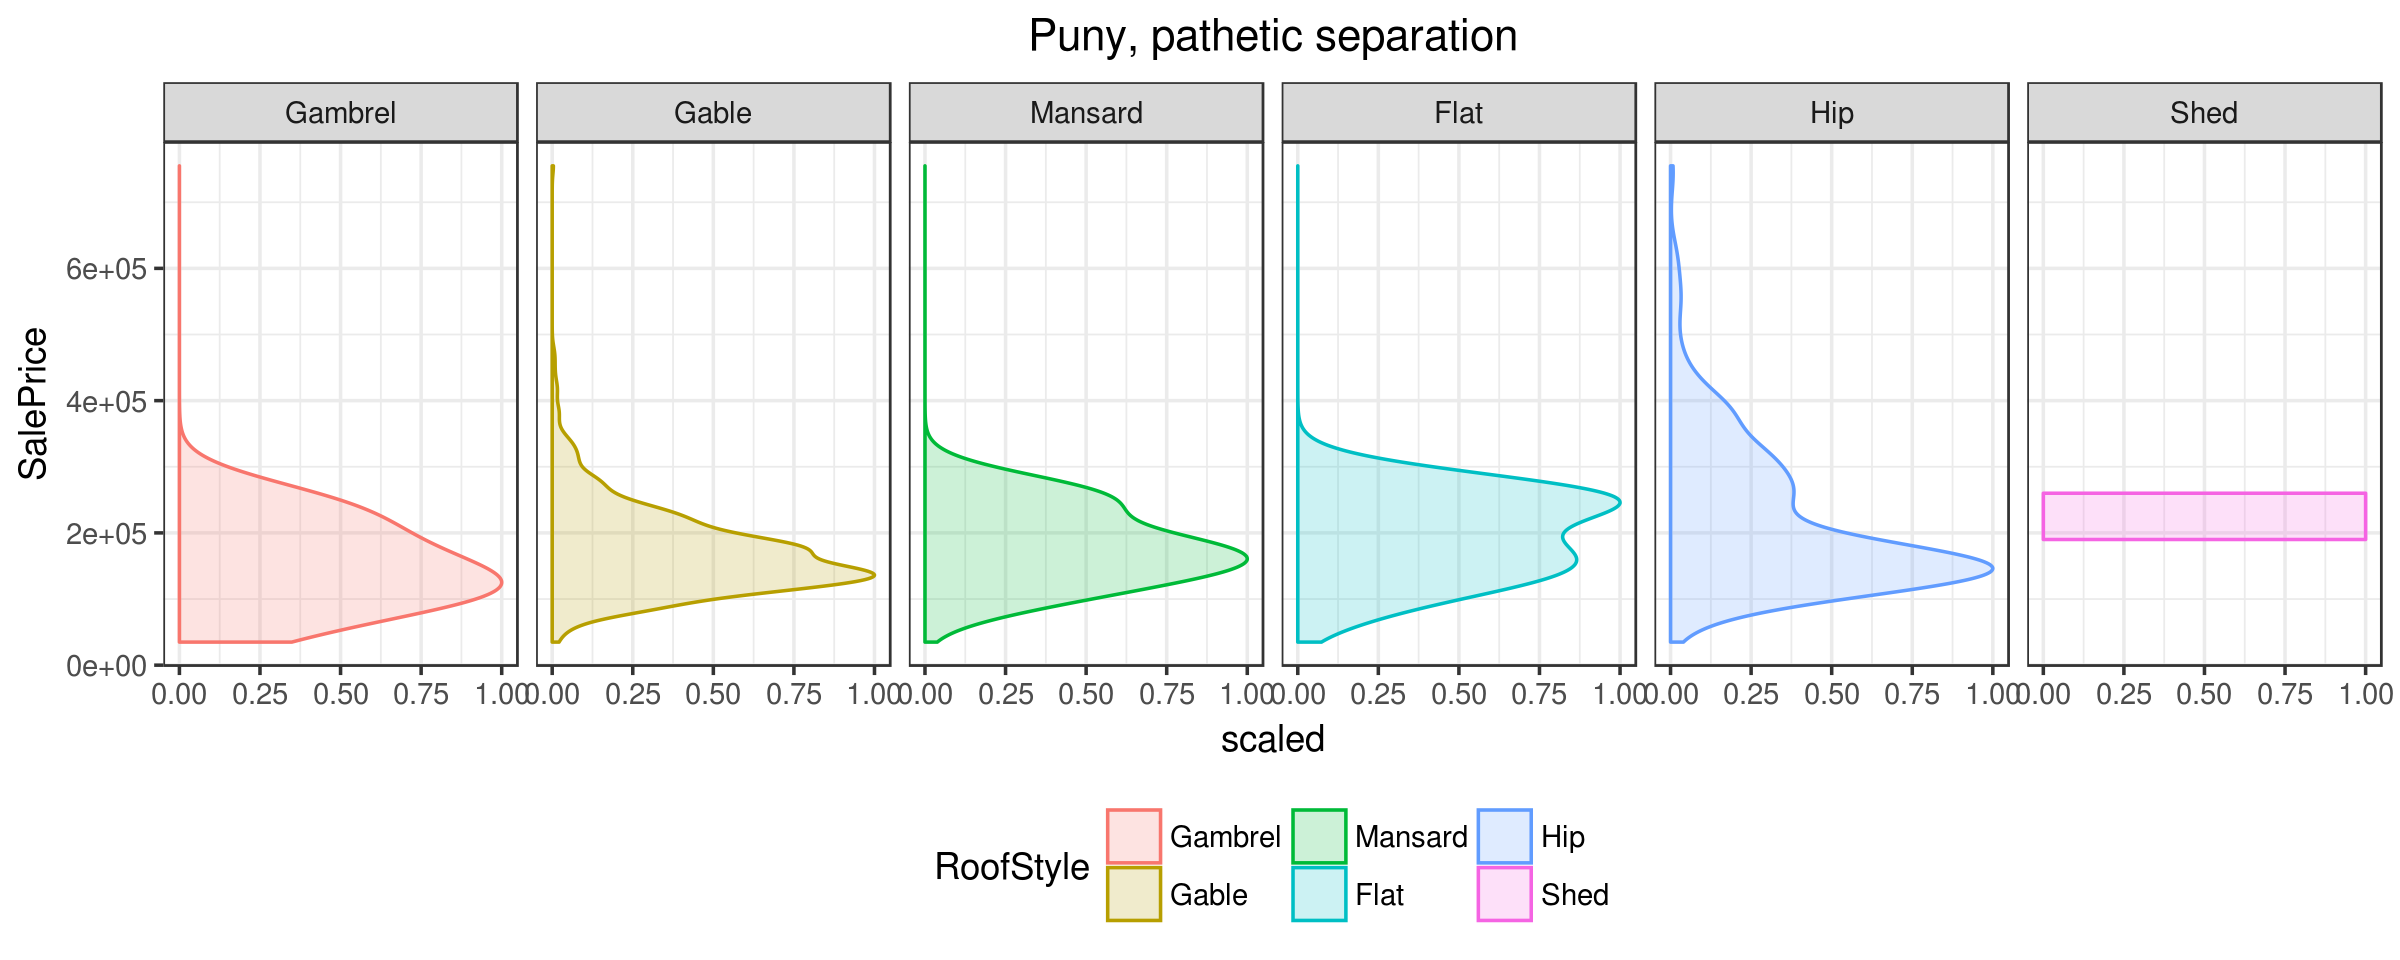

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=240)

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Noticeable separation")

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(RoofStyle, SalePrice), 
    factor_var = RoofStyle, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Puny, pathetic separation")

### Ordering factors by $R^2$ of $log(SalePrice) \sim factor$

In [12]:
Rsquared <- house_prices$attributes_selection$Rsquared
sim
categ_vars_by_r2 <- 
    Rsquared$arrange_vars(
        df = categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice), 
        target_var = price_log
    )
numeric_vars_by_r2 <- 
    Rsquared$arrange_vars(
        df = numeric_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice), 
        target_var = price_log
    )

show_table(
    categ_vars_by_r2 %>% head(8), 
    categ_vars_by_r2 %>% tail(8)
)

show_table(
    numeric_vars_by_r2 %>% head(8), 
    numeric_vars_by_r2 %>% tail(8)
)

var,r2
Utilities,0.0001595693
LandSlope,0.0014844628
Street,0.0032912275
BsmtFinType2,0.0070511837
MoSold,0.0074925710
Condition2,0.0120393620
RoofMatl,0.0179000011
LotConfig,0.0233390161
var,r2
Foundation,0.3036511


var,r2
BsmtFinSF2,2.335219e-05
BsmtHalfBath,2.651317e-05
MiscVal,4.008332e-04
OverallCond,1.359249e-03
YrSold,1.388529e-03
LowQualFinSF,1.441174e-03
X3SsnPorch,3.014035e-03
PoolArea,4.871734e-03
var,r2
YearBuilt,0.3440646


# By Fisher statistics

### Basically one-way ANOVA

For datailed comparison with Python see `learn/anova_separation` notebook.

In [13]:
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

Q_table <- anova$Q_table(df, price_log)
Q_table %>% head

# control
# should be close to zero
max((Q_table$Q_total - (Q_table$Q_within_groups + Q_table$Q_of_groups))) %>% show_list

categ_vars_by_fisher <- anova$arrange_vars(df, price_log)

show_table(
    categ_vars_by_fisher %>% head, 
    categ_vars_by_fisher %>% tail
)

var,num_levels,num_observ,Q_within_groups,Q_of_groups,Q_total
Alley,3,1460,226.3667,6.433964,232.8007
BldgType,5,1460,223.4560,9.344708,232.8007
BsmtCond,5,1460,212.6312,20.169471,232.8007
BsmtExposure,5,1460,199.6048,33.195897,232.8007
BsmtFinType1,7,1460,179.8018,52.998896,232.8007
BsmtFinType2,7,1460,222.7261,10.074509,232.8007


3.41060513164848e-13

var,F
Utilities,0.2326891
MoSold,0.9937405
LandSlope,1.0830389
Condition2,2.5277400
MiscFeature,3.6212358
RoofMatl,3.7806452
var,F
FireplaceQu,131.1985
CentralAir,205.6670
GarageFinish,298.7698


# Discarding weak categorical variables

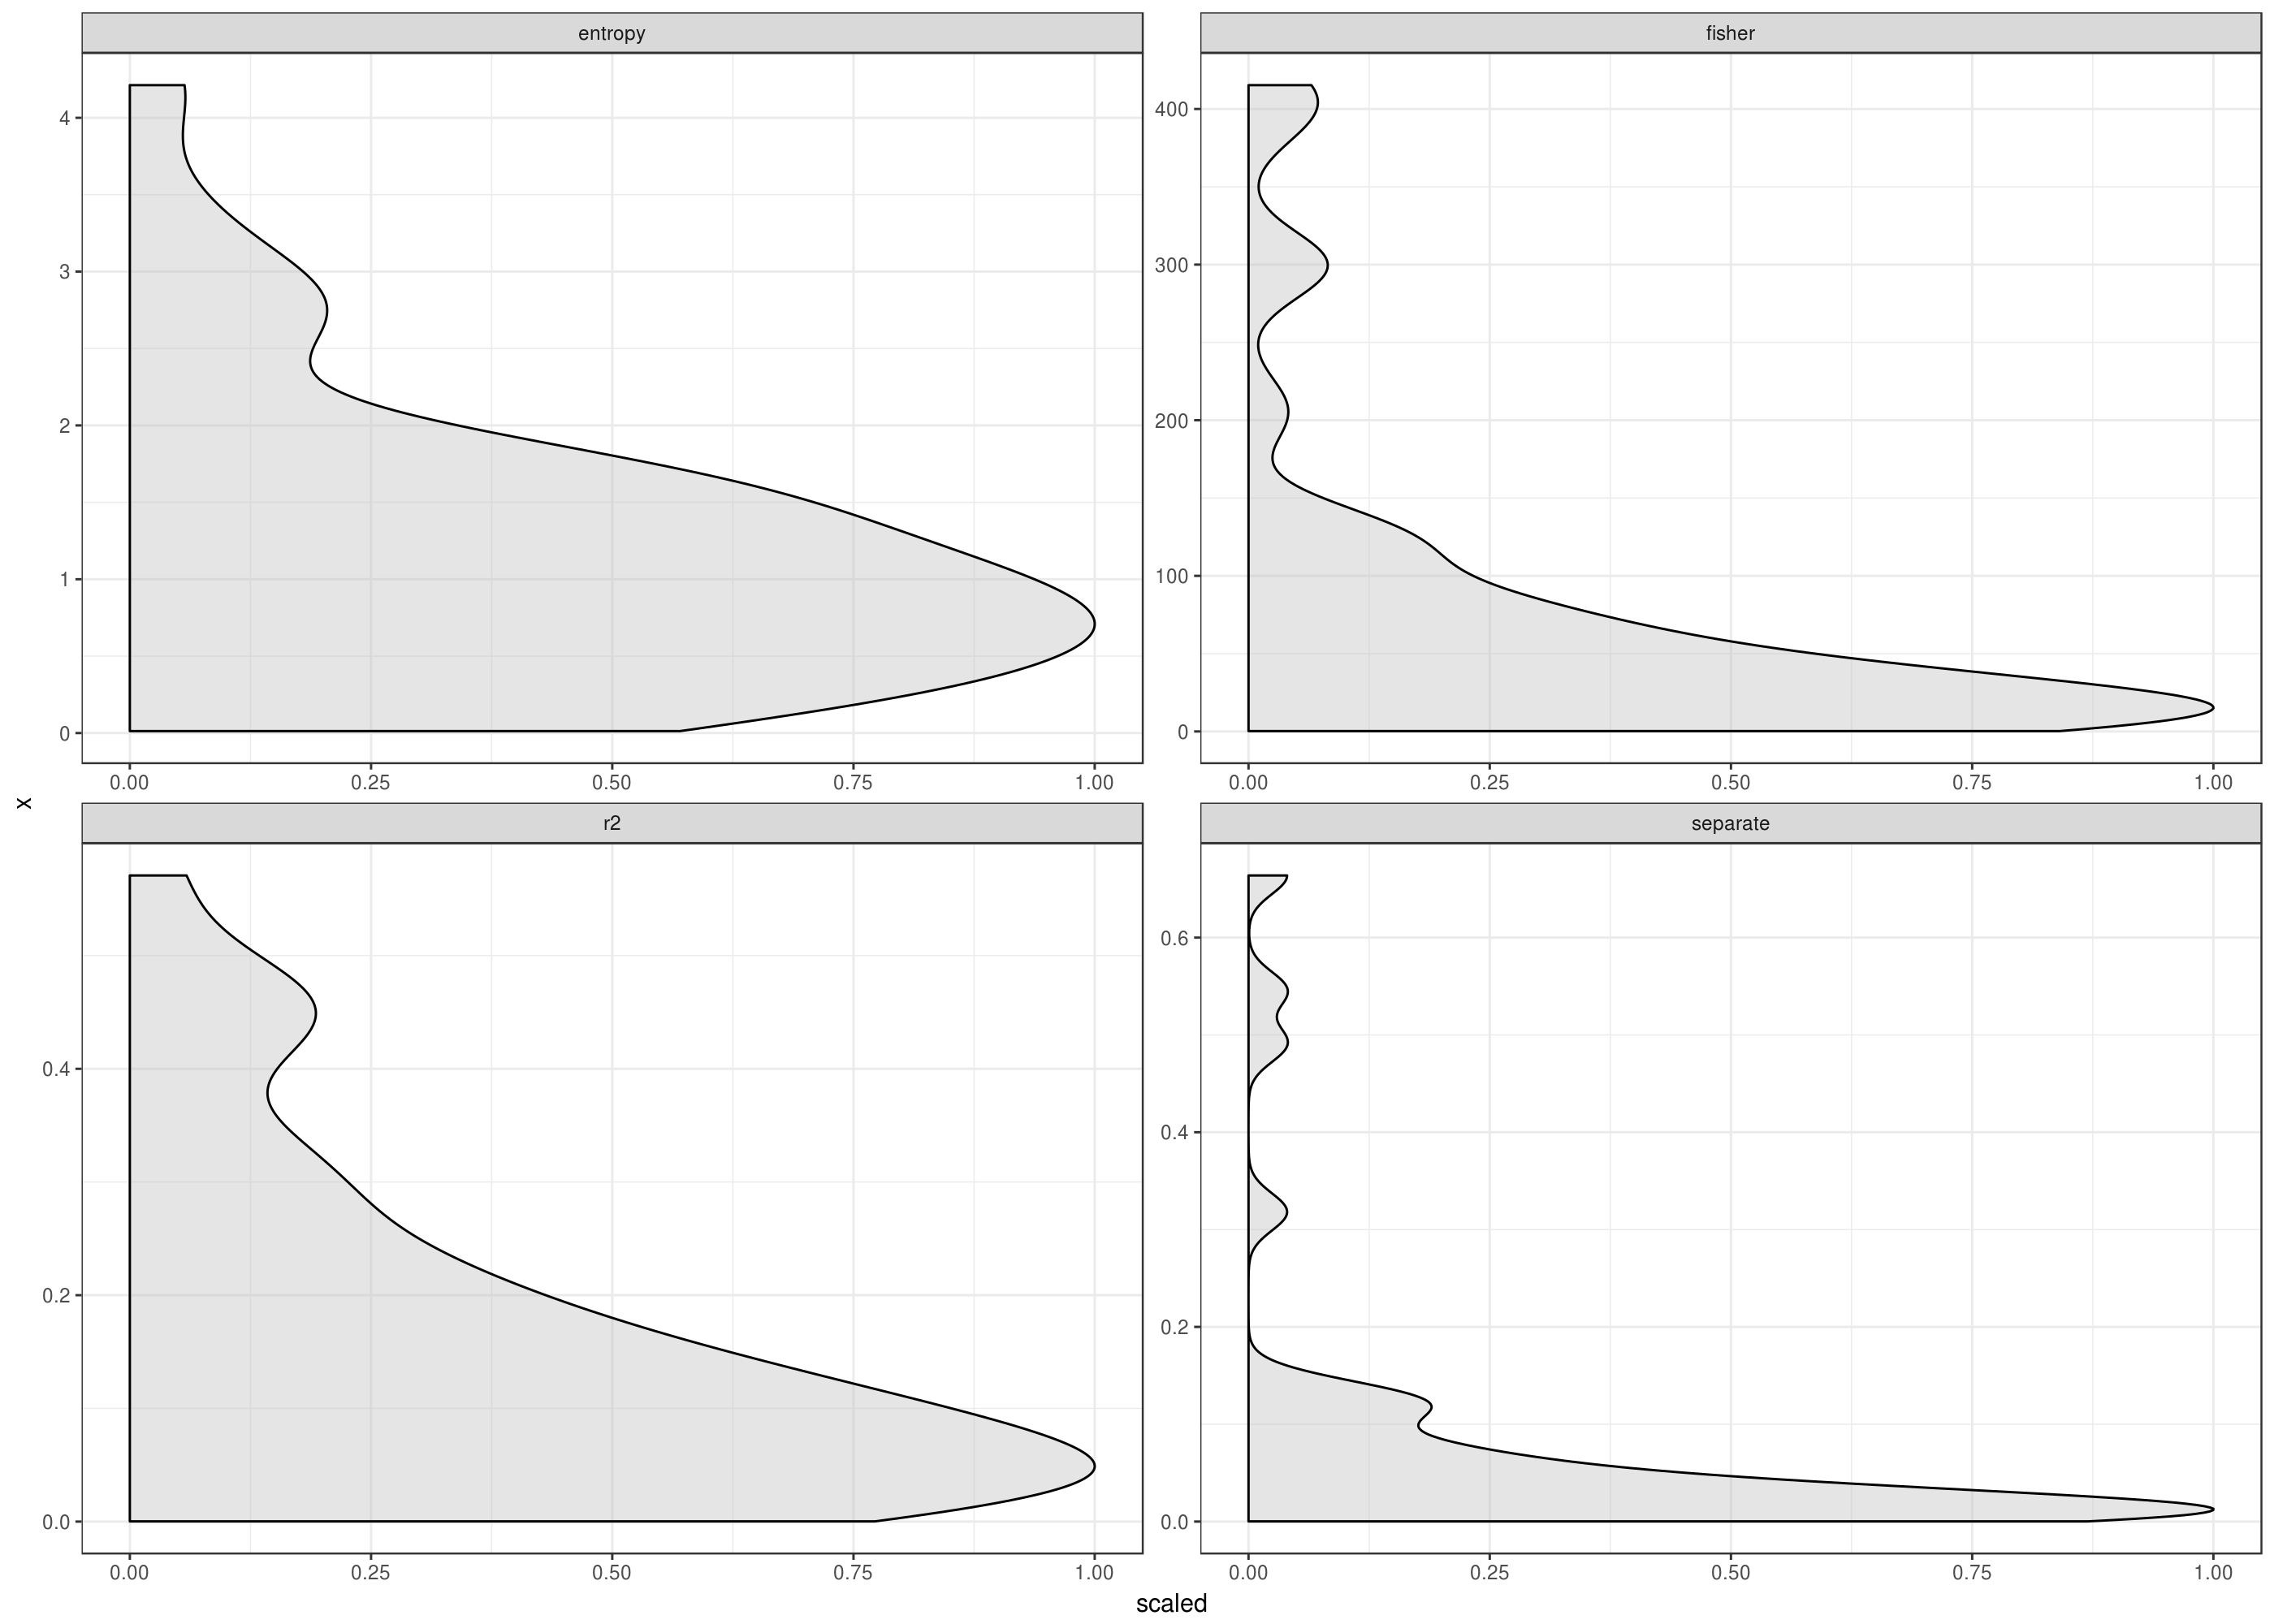

In [14]:
options(repr.plot.width = 14, repr.plot.height = 10, repr.plot.res=200)

entropy <- house_prices$attributes_selection$entropy
groups_separation <- house_prices$attributes_selection$groups_separation
Rsquared <- house_prices$attributes_selection$Rsquared
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

cat_by_entropy <- entropy$arrange_vars(df %>% select(-price_log))
cat_by_groups_separation <- groups_separation$arrange_vars(df, price_log)
cat_by_r2 <- Rsquared$arrange_vars(df, price_log)
cat_by_fisher <- anova$arrange_vars(df, price_log)

bind_rows(
    cat_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    cat_by_groups_separation %>% mutate(method = 'separate') %>% rename(x=score),
    cat_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2),
    cat_by_fisher %>% mutate(method = 'fisher') %>% rename(x=F)
) %>% 
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=2, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [15]:
x1 <- cat_by_entropy %>% filter(entropy < 1) %>% `[[`('var')
x2 <- cat_by_groups_separation %>% filter(score < 0.2) %>% `[[`('var')
x3 <- cat_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')
x4 <- cat_by_fisher %>% filter(F < 100) %>% `[[`('var')

cat_virgin_vars <- Reduce(intersect, list(x1, x2, x3, x4)) %>% sort
cat_chad_vars <- setdiff(categ_data %>% colnames, cat_virgin_vars) %>% sort

# weak attributes
cat_virgin_vars %>% show_list
# strong attributes
cat_chad_vars %>% show_list

BldgType BsmtCond BsmtFinType2 Condition1 Condition2 Electrical ExterCond Functional GarageCond GarageQual Heating LandContour LandSlope PavedDrive RoofMatl RoofStyle Street Utilities

Alley BsmtExposure BsmtFinType1 BsmtQual CentralAir Exterior1st Exterior2nd ExterQual Fence FireplaceQu Foundation GarageFinish GarageType HeatingQC HouseStyle KitchenQual LotConfig LotShape MasVnrType MiscFeature MoSold MSSubClass MSZoning Neighborhood PoolQC SaleCondition SalePrice SaleType

## Eyeballing weak categorical attributes

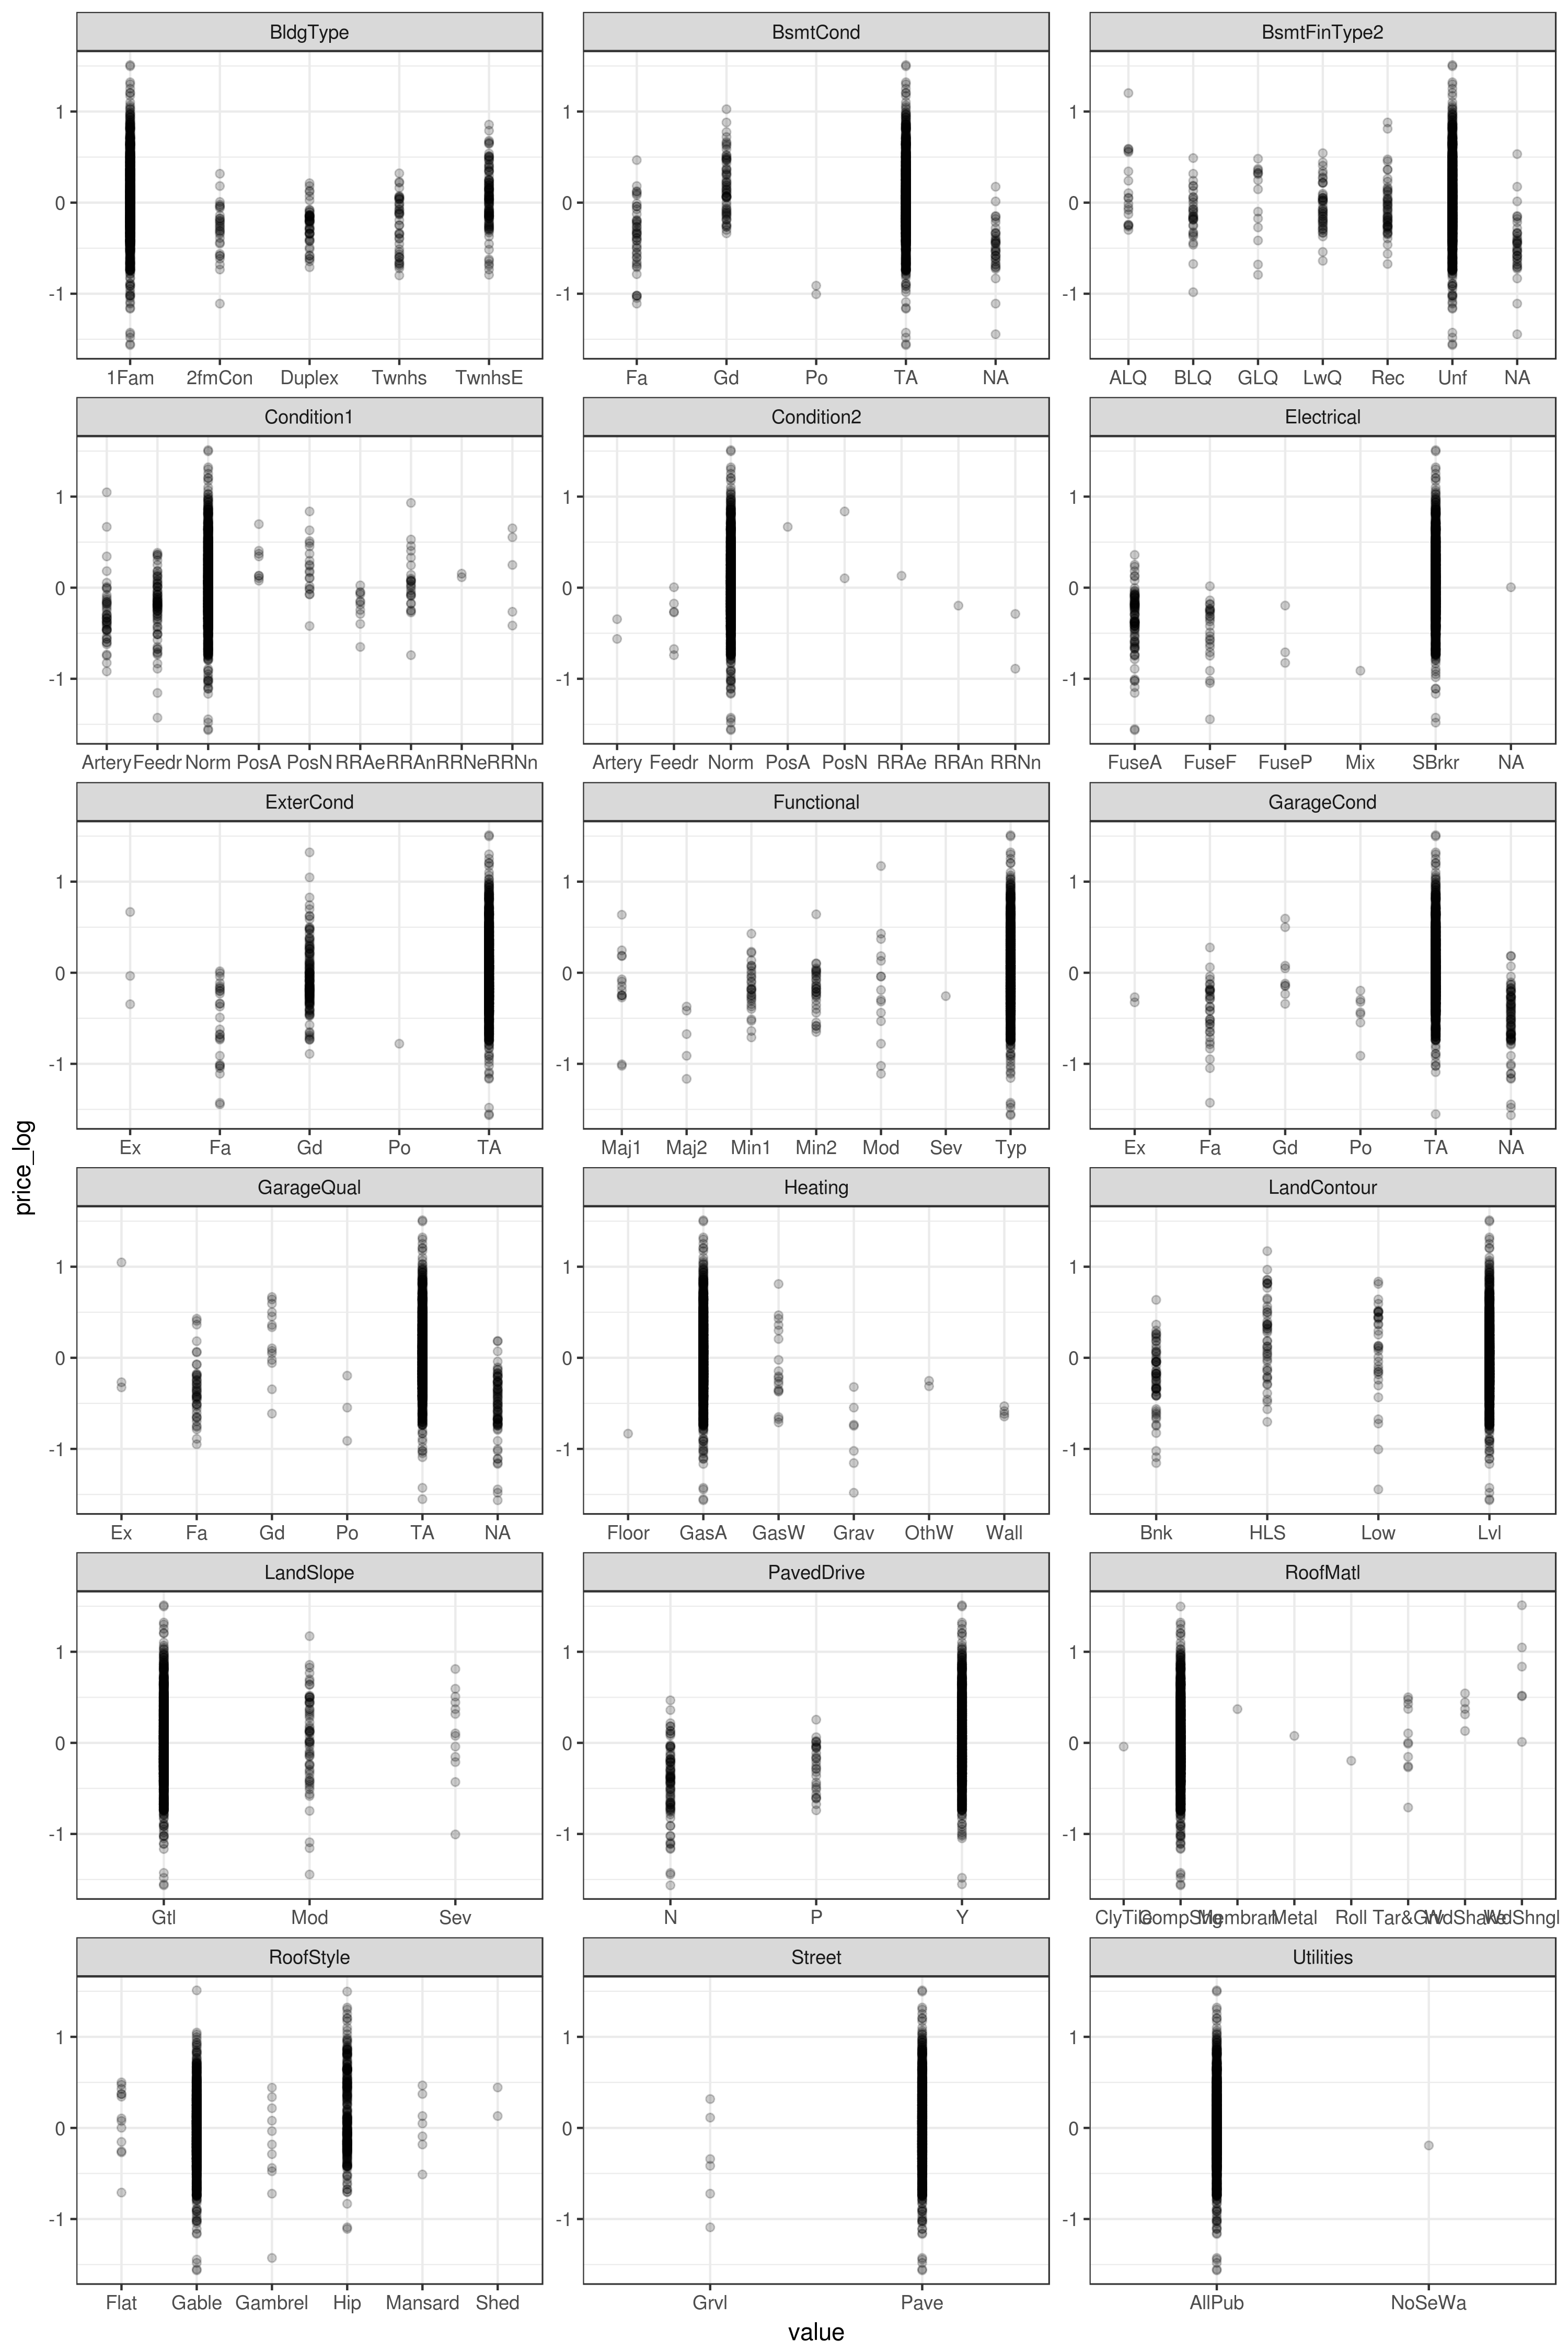

In [16]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res=300)

categ_data %>%
mutate(price_log = log(SalePrice)) %>%
select(one_of(cat_virgin_vars), price_log) %>%
filter(!is.na(price_log)) %>%
gather(var, value, -price_log) %>%
mutate(
    price_log = price_log - mean(price_log)
) %>%
ggplot(aes(x = value, y = price_log)) +
geom_point(alpha = 0.2) +
facet_wrap(~var, ncol=3, scale="free") +
theme_bw()

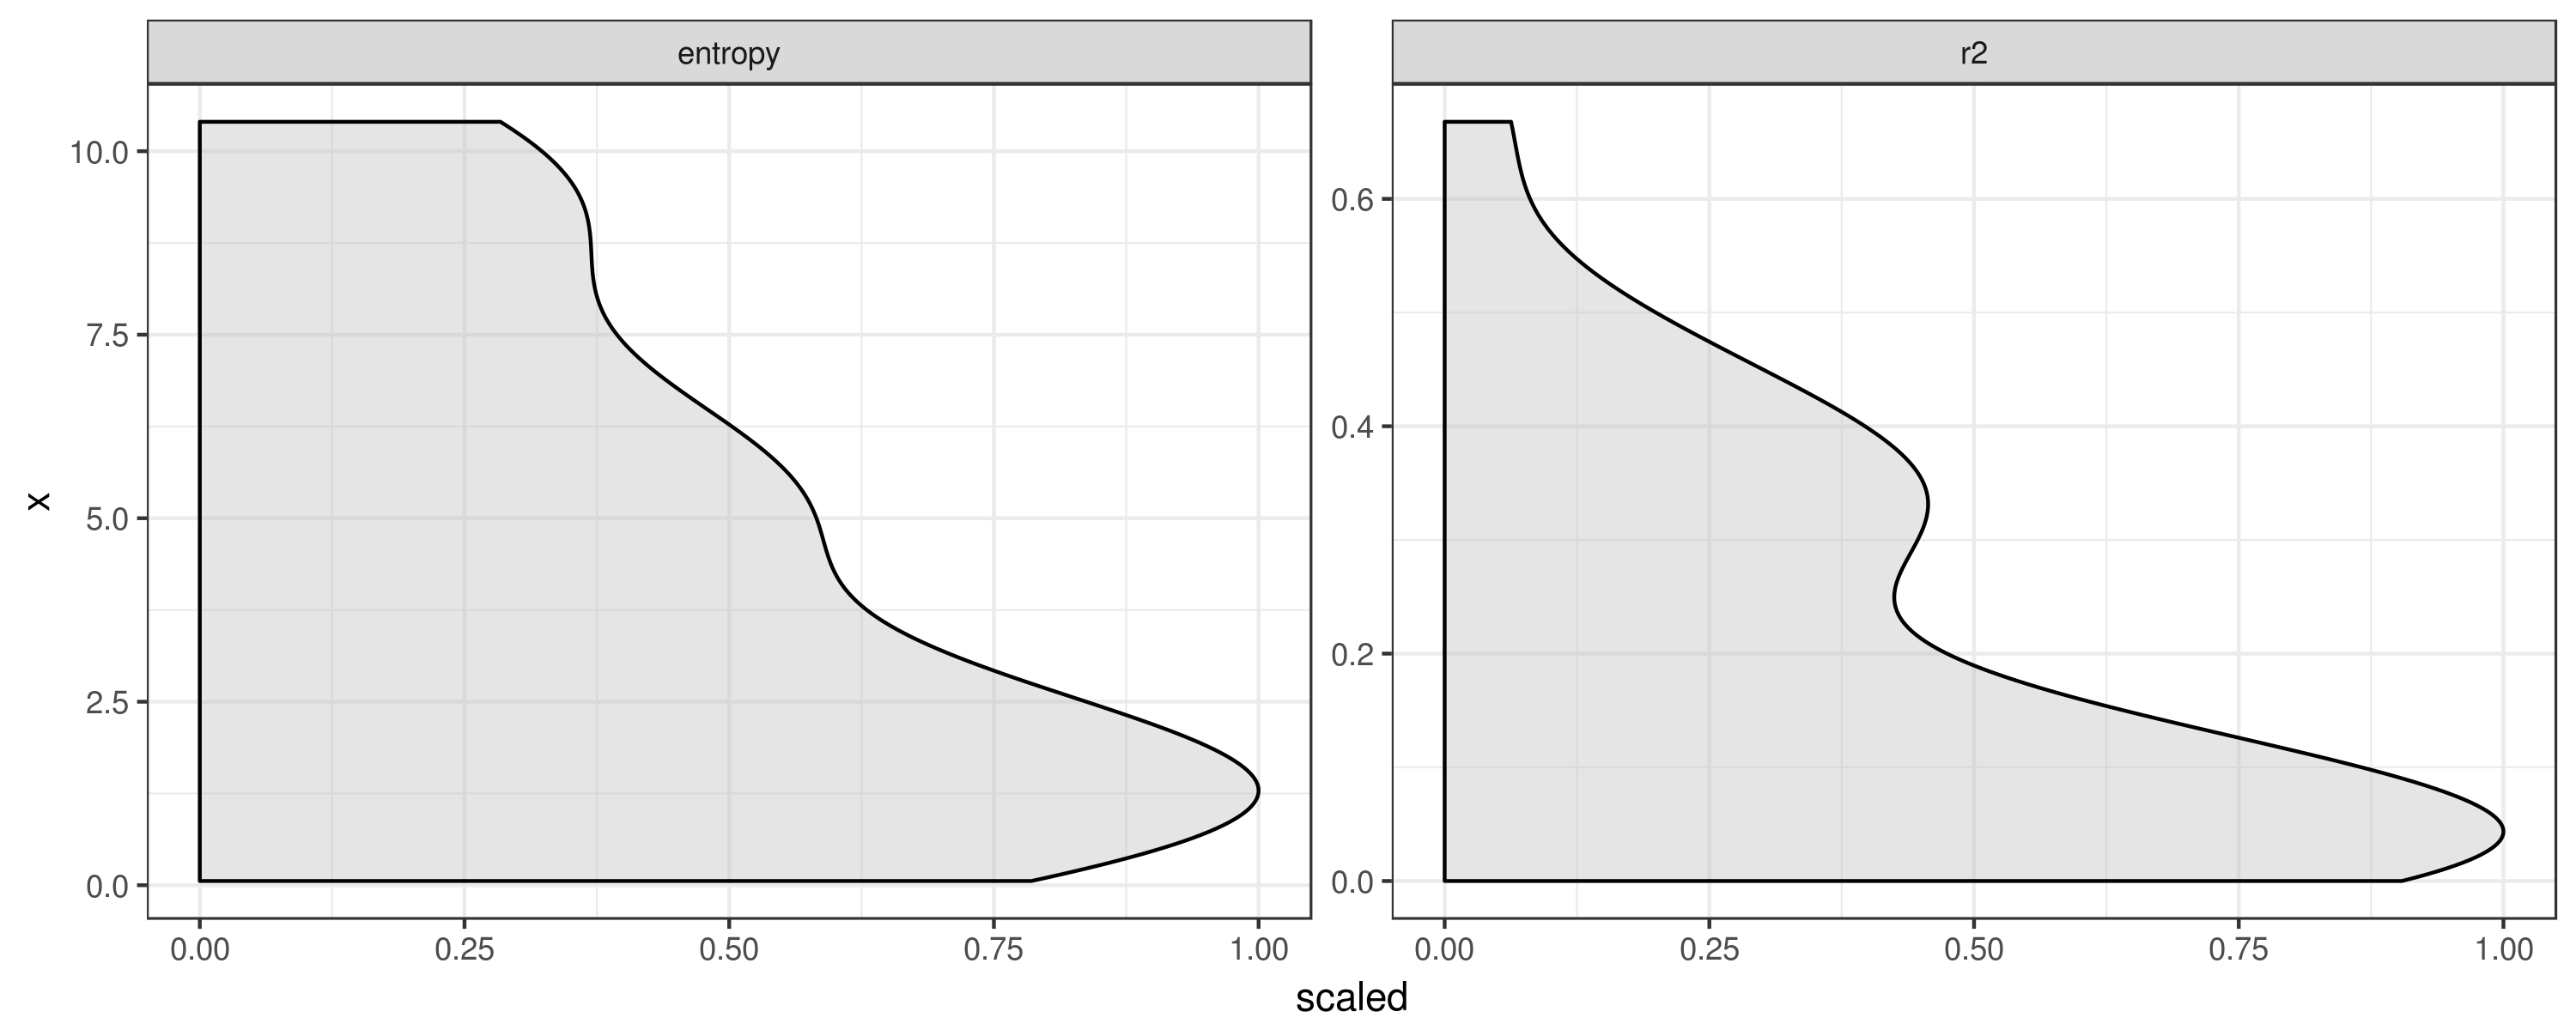

In [17]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=300)

df <- numeric_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

num_by_entropy <- entropy$arrange_vars(df)
num_by_r2 <- Rsquared$arrange_vars(df, price_log)

bind_rows(
    num_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    num_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2)
) %>%
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=1, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [18]:
x1 <- num_by_entropy %>% filter(entropy < 2) %>% `[[`('var')
x2 <- num_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')

num_virgin_vars <- Reduce(intersect, list(x1, x2)) %>% sort
num_chad_vars <- setdiff(numeric_data %>% colnames, num_virgin_vars) %>% sort

# weak attributes
num_virgin_vars %>% show_list
# strong attributes
num_chad_vars %>% show_list

BedroomAbvGr BsmtFinSF2 BsmtFullBath BsmtHalfBath EnclosedPorch HalfBath KitchenAbvGr LowQualFinSF MiscVal OverallCond PoolArea ScreenPorch X3SsnPorch

BsmtFinSF1 BsmtUnfSF Fireplaces FullBath GarageArea GarageCars GarageYrBlt GrLivArea LotArea LotFrontage MasVnrArea OpenPorchSF OverallQual SalePrice TotalBsmtSF TotRmsAbvGrd WoodDeckSF X1stFlrSF X2ndFlrSF YearBuilt YearRemodAdd YrSold

### Eyeballing weak numeric attributes

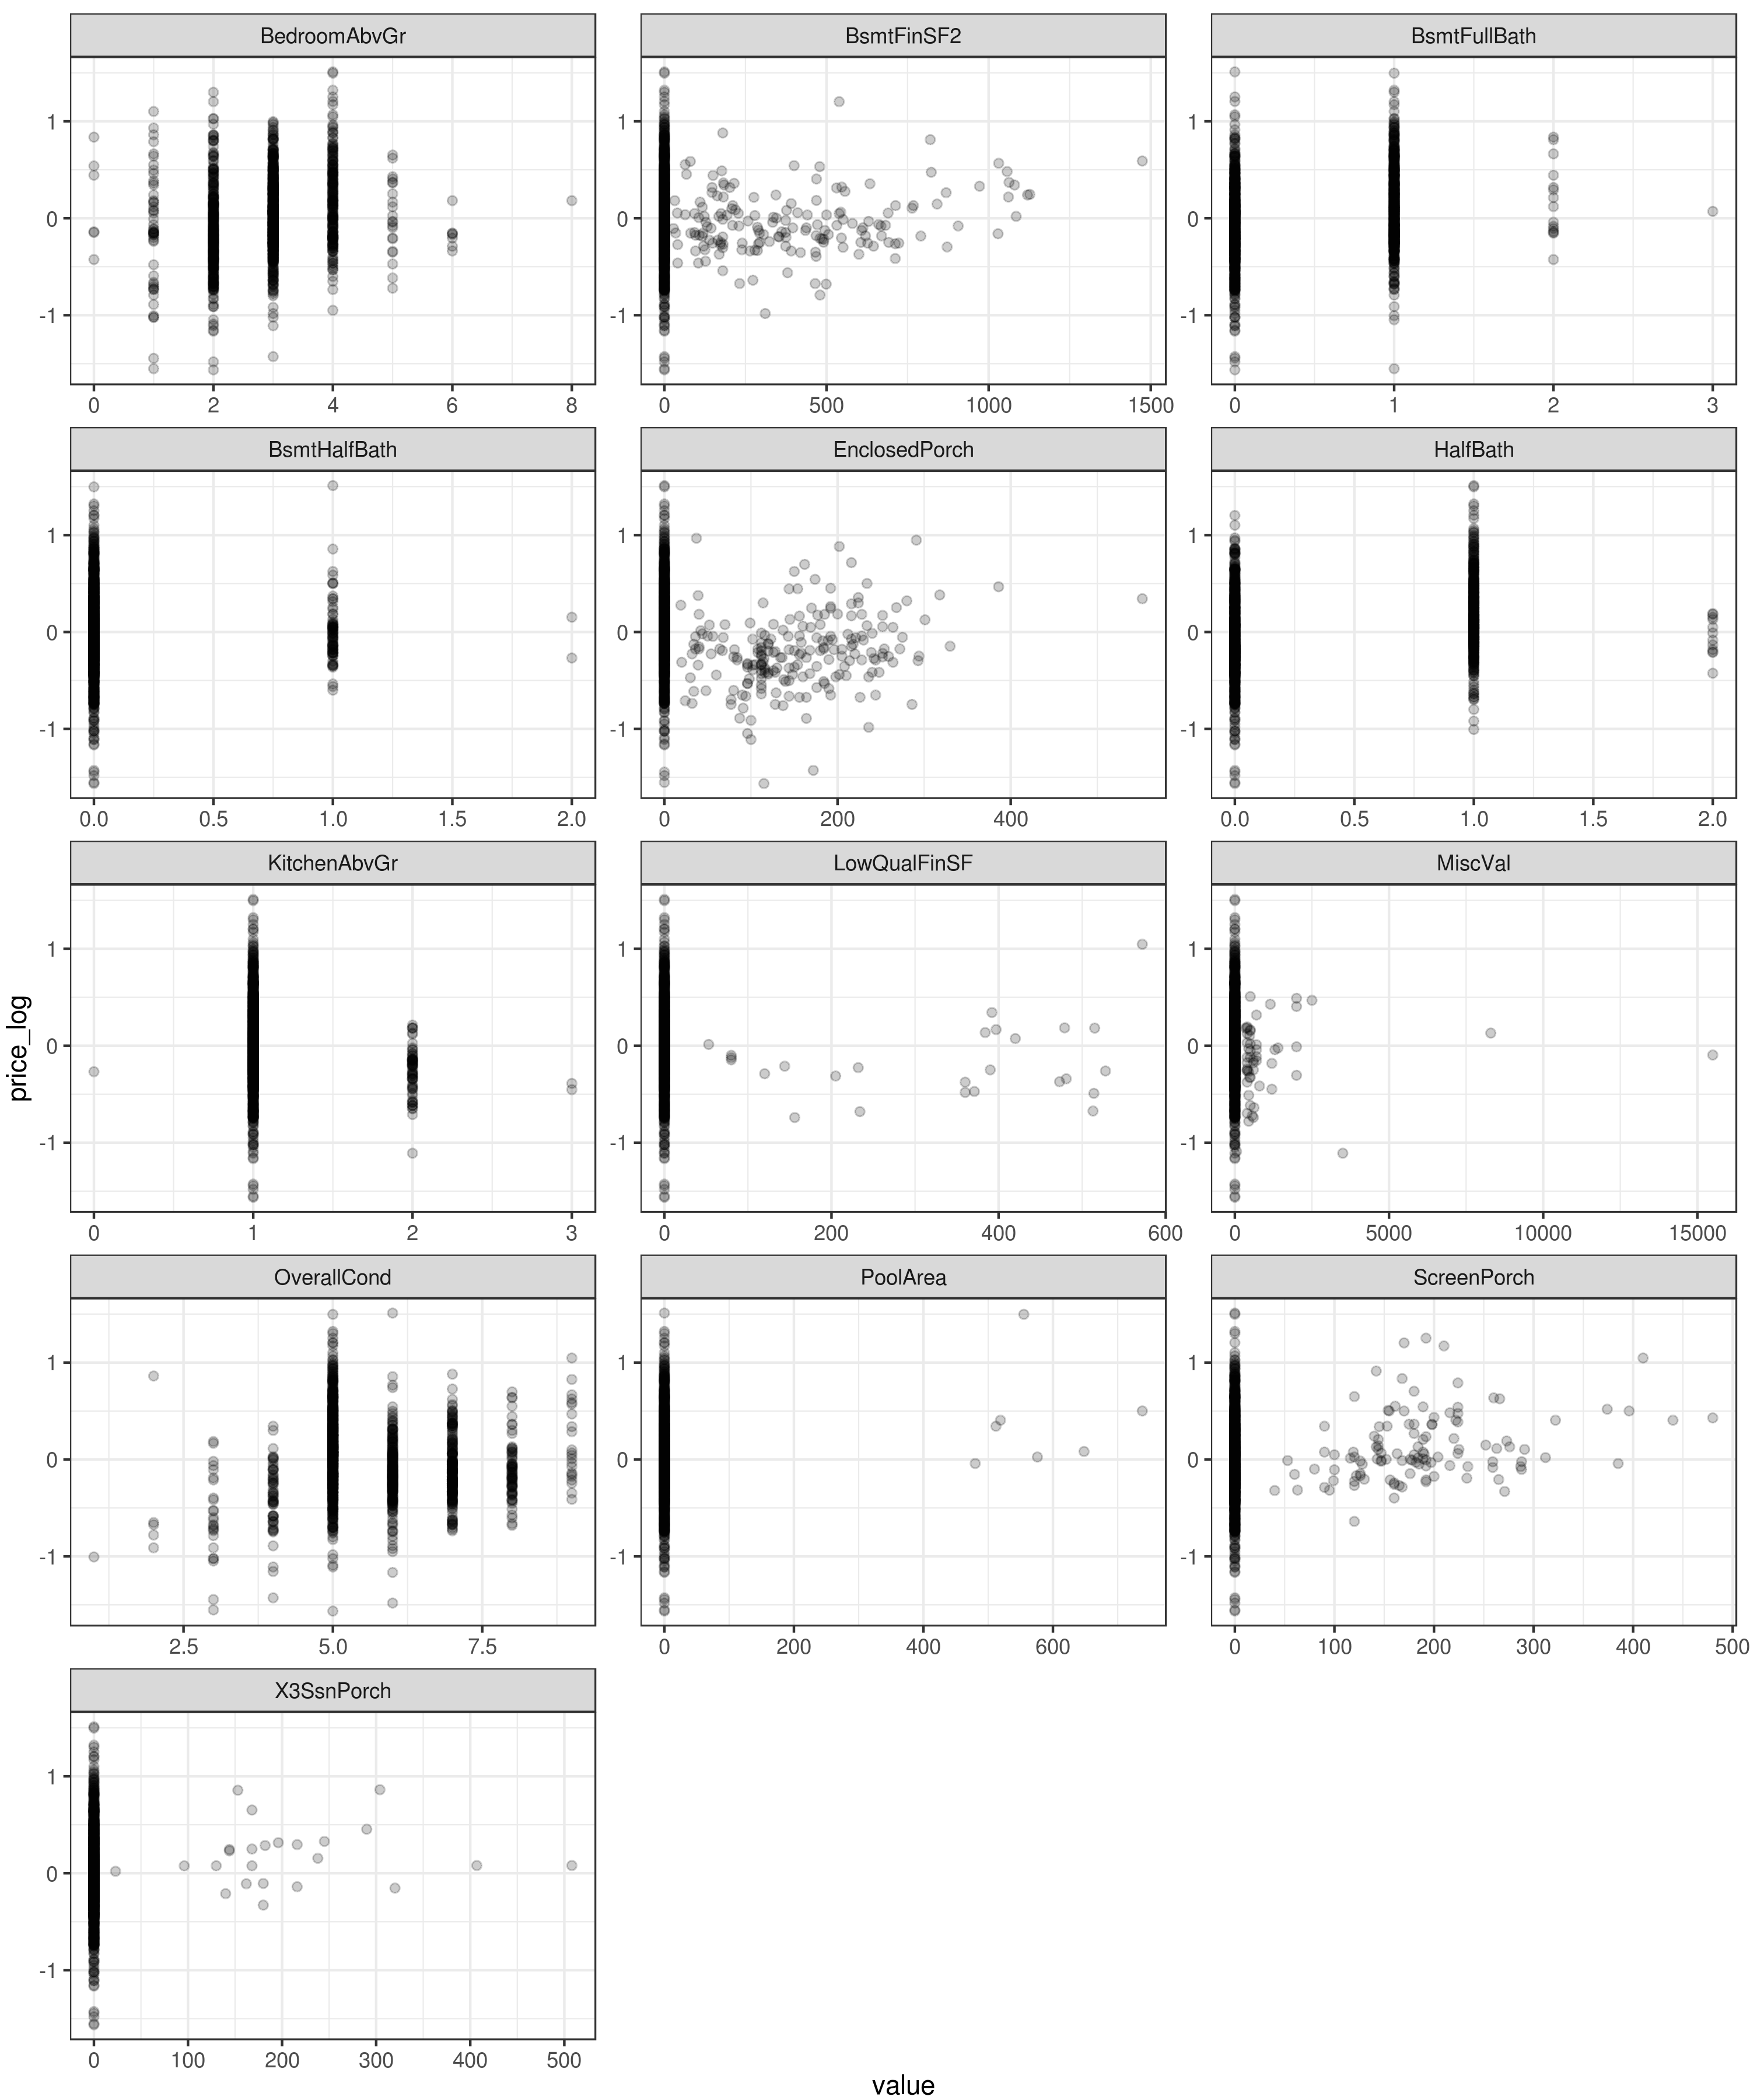

In [19]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res=300)

numeric_data %>%
mutate(price_log = log(SalePrice)) %>%
select(one_of(num_virgin_vars), price_log) %>%
filter(!is.na(price_log)) %>%
gather(var, value, -price_log) %>%
mutate(
    price_log = price_log - mean(price_log)
) %>%
ggplot(aes(x = value, y = price_log)) +
geom_point(alpha = 0.2) +
facet_wrap(~var, ncol=3, scale="free") +
theme_bw()